# Criteria for Truncated SVD: Python codes

In [1]:
#Necessary libraries to be imported:
import numpy as np
import scipy.linalg as spl
from scipy.interpolate import interp1d
import scipy.integrate as spi
from KDEpy import FFTKDE
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


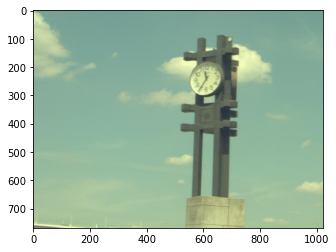

In [2]:
#Loading and plotting the firts image:
img = mpimg.imread('0002.jpg')
imgplot = plt.imshow(img)

shape of original image (768, 1024, 3)
shape gray scale (768, 1024)


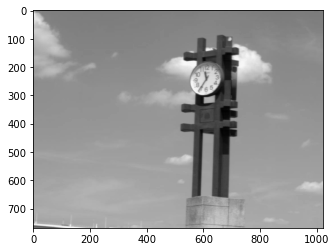

In [3]:
#Gray-scale transformation
print('shape of original image',img.shape)
rgb_weights = [0.2989, 0.5870, 0.1140]
imgg=np.dot(img,rgb_weights)
print('shape gray scale',imgg.shape)
imgplot = plt.imshow(imgg,cmap=plt.get_cmap("gray"))

In [4]:
#SVD computation
Uimg, sigm, Vimg = spl.svd(imgg, full_matrices=False)
r = np.linalg.matrix_rank(imgg)

# Scree plot

Text(0, 0.5, 'log singular values')

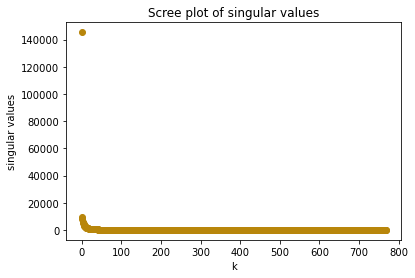

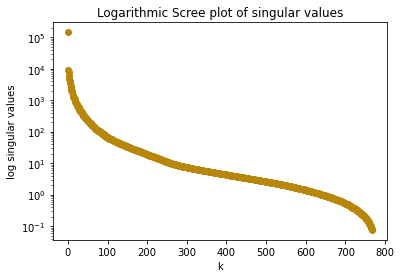

In [5]:
#Scree plot of the singular values
plt.figure()
plt.plot(np.linspace(0,len(sigm),len(sigm)),sigm,'o', color='darkgoldenrod')
plt.title('Scree plot of singular values')
plt.xlabel('k')
plt.ylabel('singular values')
plt.figure()
plt.semilogy(np.linspace(0,len(sigm),len(sigm)),sigm,'o', color = 'darkgoldenrod')
plt.title('Logarithmic Scree plot of singular values')
plt.xlabel('k')
plt.ylabel('log singular values')

We use the logarithmic Scree plot as for the standard Scree plot is not easy to see the carachteristic "elbow" shape

In [6]:
Sigma_scree= sigm[0:300]*np.eye(300,300)
Rec_scree = np.dot(Uimg[:,0:300], np.dot(Sigma_scree,Vimg[0:300,:]))

print('\n Relative error with logarithmic Scree plot: ', np.linalg.norm(imgg-Rec_scree)/sigm[0])


 Relative error with logarithmic Scree plot:  0.00048448281963696854


# Guttman-Kaiser criterion

Choose the first $k$ singular values such that: $\forall i >k, \sigma_i<1$.

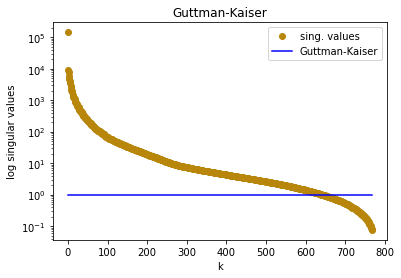

In [7]:
plt.figure()
plt.semilogy(np.linspace(0,len(sigm),len(sigm)),sigm,'o', color='darkgoldenrod',label = 'sing. values')
plt.plot(np.linspace(0,len(sigm),len(sigm)), np.ones([len(sigm),1]),'-b', label = 'Guttman-Kaiser')
plt.title('Guttman-Kaiser')
plt.xlabel('k')
plt.ylabel('log singular values')
plt.legend()

In [8]:
Sigma_GK= sigm[0:600]*np.eye(600,600)
Rec_GK = np.dot(Uimg[:,0:600], np.dot(Sigma_GK,Vimg[0:600,:]))

print('\n Relative error with Gutman-Kaiser criterion: ', np.linalg.norm(imgg-Rec_GK)/sigm[0])


 Relative error with Gutman-Kaiser criterion:  6.905372329328467e-05


# Broken-stick 

In [9]:
def brokenStick(s):
    l = len(s)
    b = np.zeros([1,l])

    for i in range(len(s)):
        
        b[0,i] = np.sum(np.linspace(i,l,l-i))
    
    return b/l

In [10]:
br = brokenStick(sigm)

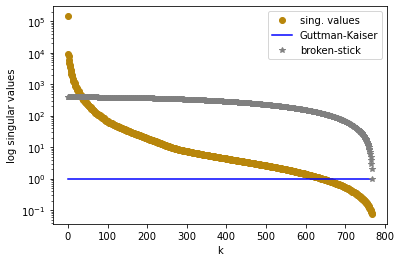

In [11]:
plt.figure()
plt.semilogy(np.linspace(0,len(sigm),len(sigm)),sigm,'o', color='darkgoldenrod',label = 'sing. values')
plt.plot(np.linspace(0,len(sigm),len(sigm)), np.ones([len(sigm),1]),'-b', label = 'Guttman-Kaiser')
plt.semilogy(np.linspace(0,len(sigm),len(sigm)), br[0,:], '*', color ='gray', label = 'broken-stick' )
#plt.title('')
plt.xlabel('k')
plt.ylabel('log singular values')
plt.legend()

In [12]:
Sigma_bstick= sigm[0:60]*np.eye(60,60)
Rec_bstick = np.dot(Uimg[:,0:60], np.dot(Sigma_bstick,Vimg[0:60,:]))

print('\n Relative error with broken-stick: ', np.linalg.norm(imgg-Rec_bstick)/sigm[0])


 Relative error with broken-stick:  0.005577044096581399


# Random-projection range finder

In [13]:
#Choose a tolerance:
tol = 1e-3

def range_finder(A,tol,max_it):
    
#Generate a list for the approximation error
    err = []
    err.append(1)
#Size of the input matrix    
    [m,n] = A.shape
    
    l = 1
    it = 0
    while((err[-1]>tol) & (it<max_it)):
    
#1. Draw an n × l Gaussian random matrix Ω
       Omega = np.random.randn(n,l)

#2. Form the m × l sample matrix Y = AΩ.
       Y = np.dot(A,Omega)

#3. Form an m × l orthonormal matrix Q such that Y = QR.
       [Q,R]=spl.qr(Y,pivoting=False)
    
#Add the error for this iteration
       err.append(np.linalg.norm(A- np.dot(Q[:,0:l],np.dot((Q[:,0:l]).T,A))))
       it = it+1
       l = l+1
    l = l-1
#4. Form the l × n matrix B = Q_l*A.
    B = np.dot((Q[:,0:l]).T, A)

#5. Compute the SVD of the small matrix B: B = \hat{U}ΣV*.
    [Uhat, Sigma, V] = spl.svd(B)

#6. Form the matrix U = Q_l(\hat{U}).
    U = np.dot(Q[:,0:l],Uhat)
    
    return l,err,it,U,Sigma,V

In [14]:
k,error,n_it,Ur,Sigmar,Vr = range_finder(imgg,tol,100)

In [15]:
print("\n Number of singular values ", k)
print("\n error at the last iteration ", error[-1])
print("\n Number of required iterations ", n_it)


 Number of singular values  100

 error at the last iteration  839.4513970320131

 Number of required iterations  100


In [16]:
#Reconstructed image
Sigmarr = Sigmar[0:k]*np.eye(k,k)
Recon = np.dot(Ur, np.dot(Sigmarr,Vr[0:k,:]))

In [17]:
print("\n approximation error ", np.linalg.norm(imgg-Recon))
print ("\n sigma_{k+1} ", sigm[k+1])

print("\n Relative error ", np.linalg.norm(imgg-Recon)/sigm[0])



 approximation error  839.4513970320133

 sigma_{k+1}  65.49845842917813

 Relative error  0.0057711523147612465


In this case we do not have the control of the error as the algoirthm exits due to maximal number of iterations reached rather than set accuracy reached.

# Entropy

In [18]:
f = sigm**2/np.sum(sigm**2)
E = -1/np.log(r)*np.sum(f*np.log(f))
print('\n Entropy ', E)


 Entropy  0.015062674090159548


In [19]:
E_p70 = int(r*0.7*E) # 70% of total Entropy
print('\n number of singular values to retain to keep 70% ', E_p70)
E_p90 = int(r*0.9*E)
print('\n number of singular values to retain to keep 90% ', E_p90)



 number of singular values to retain to keep 70%  8

 number of singular values to retain to keep 90%  10


In [20]:
#Reconstructed image
Sigma_Ep70 = sigm[0:E_p70]*np.eye(E_p70,E_p70)
Sigma_Ep90 = sigm[0:E_p90]*np.eye(E_p90,E_p90)

Rec_Ep70 = np.dot(Uimg[:,0:E_p70], np.dot(Sigma_Ep70,Vimg[0:E_p70,:]))
Rec_Ep90 = np.dot(Uimg[:,0:E_p90], np.dot(Sigma_Ep90,Vimg[0:E_p90,:]))

print('\n Relative error with 70% ', np.linalg.norm(imgg-Rec_Ep70)/sigm[0])
print('\n Relative error with 90% ', np.linalg.norm(imgg-Rec_Ep90)/sigm[0])


 Relative error with 70%  0.04216170665296159

 Relative error with 90%  0.0355028418238158


# Total variance

In [21]:
tot_var = np.sum(sigm**2)
print('\n total variance ', tot_var)
print('\n 10% of total variance ', 0.05*tot_var )


 total variance  21441023776.228905

 10% of total variance  1072051188.8114452


In [22]:
trova = np.log(sigm)>(0.05*tot_var)
print(np.where(trova == True))

(array([], dtype=int64),)


Not significant criterion for this type of situation. Too big magnitude of the first singular value.

# Percentage cumulative variance

In [23]:
t_star = 0.90;
val = np.cumsum(sigm**2)/np.sum(sigm**2)
print(np.min(val))
ind_k = val>t_star


0.9867804140986804


In this case, since the minimum of the computed cumulative variance is bigger than the treshold values, then, every singular value is considered significant. 

# Kass-Raftery 1965

In [24]:
[m,n] = imgg.shape
Stiefel_dim = m*n -n*(n+1)/2 #global
v_hat = np.zeros([1,r])
p_vec = v_hat
log_s = np.log(sigm)
for j in range(r-1):
    num = np.sum((sigm[j+1:r])**2)
    v_hat[0,j] = num/(r-j)
    e = -r*(r-j)*0.5
    if((v_hat[0,j]**e)>0.0):
        p_vec[0,j] = (np.prod(sigm[0:j]**2))**(r/2)*(v_hat[0,j]**e)*r**(-(Stiefel_dim+j)*0.5)
    else:
        print("\n inconsistent probabilities")
if(np.max(p_vec)!=0):
    ind_p = np.where(np.max(p_vec))


 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent probabilities

 inconsistent

C:\Users\antonella\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\antonella\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\antonella\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\antonella\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


# Kullback-Leibler divergence method

In [25]:
def divergence_KL(f,r,a,b,n_pts):
    grid = np.linspace(a,b,n_pts)
    T = []
    kde = FFTKDE( kernel='tri')
    x,y= kde.fit(f).evaluate()

# Mirror the data about the domain boundary
    low_bound = 0
    data = np.concatenate((f, 2 * low_bound - f))

# Compute KDE using the bandwidth found, i.e. the parameter h, and twice as many grid points
    x, y = FFTKDE(bw=kde.bw, kernel='tri').fit(data).evaluate()
    y[x<=low_bound] = 0  # Set the KDE to zero outside of the domain
    y = y * 2  # Double the y-values to get integral of ~1
    
    kde_t = FFTKDE( kernel='tri')
    for k in range(r):
        x_t,y_t= kde_t.fit(f[0:k+1]).evaluate()
# Mirror the data about the domain boundary
        low_bound = 0
        data_t = np.concatenate((f[0:k+1], 2 * low_bound - f[0:k+1]))

# Compute KDE using the bandwidth found, and twice as many grid points
        x_t, y_t = FFTKDE(bw=kde_t.bw, kernel='tri').fit(data_t).evaluate()
        y_t[x_t<=low_bound] = 0  # Set the KDE to zero outside of the domain
        y_t = y_t * 2  # Double the y-values to get integral of ~1
        
        #Linear spline necessary only if evaluation is done at non-uniform grid
        f_linear = interp1d(x, y, kind="linear", assume_sorted=True)
        f_t_linear =interp1d(x_t, y_t, kind="linear", assume_sorted=True)
        
        Eval_f = lambda x_grid: f_linear(x_grid)*np.log(f_linear(x_grid)/f_t_linear(x_grid))
        
        T.append(spi.trapz(Eval_f(grid),grid))
        
    return T

In [26]:
tol = 1e-3
divergence = divergence_KL(f,r, 1e-13,3,30)
tupla = np.where(np.array(divergence)<tol)[0]
print("\n Numer of singular values to retain ", tupla[0])


 Numer of singular values to retain  58


In [27]:
Sigma_KL= sigm[0:tupla[0]]*np.eye(tupla[0],tupla[0])

Rec_KL = np.dot(Uimg[:,0:tupla[0]], np.dot(Sigma_KL,Vimg[0:tupla[0],:]))

print('\n Relative error with KL-method ', np.linalg.norm(imgg-Rec_KL)/sigm[0])


 Relative error with KL-method  0.00583031025952867


# Unsupervised anomaly detection based methods

In [28]:
clf = IsolationForest(random_state=0, contamination = 0.05).fit_predict(sigm.reshape(-1,1)) #-1 outliers; 1 inliners
index_s = np.where(clf==-1)
index_s = index_s[0].astype(int)
print(index_s)

Sigma_an1= sigm[index_s]*np.eye(len(index_s),len(index_s))
Rec_an1 = np.dot(Uimg[:,index_s], np.dot(Sigma_an1,Vimg[index_s,:]))

print('\n Relative error with anomaly detection, first method: ', np.linalg.norm(imgg-Rec_an1)/sigm[0])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38]

 Relative error with anomaly detection, first method:  0.009468801588735927


In [29]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(np.log(sigm.reshape(-1,1)))
lab = kmeans.labels_

Cl0 = np.where(lab==0)
Cl1 = np.where(lab==1)

l0 = len(Cl0[0])
l1 = len(Cl1[0])

if 0 in  Cl0[0]:
    clf2 = IsolationForest(random_state=0).fit_predict(np.log(sigm[Cl0[0]].reshape(-1,1))) #-1 outliers; 1 inliners
    #print("Cl0 ", Cl0)
else:
    clf2 = IsolationForest(random_state=0).fit_predict(np.log(sigm[Cl1[0]].reshape(-1,1))) #-1 outliers; 1 inliners
    #print("Cl1 ", Cl1)
indice = np.where(clf2==-1)
indice = indice[0].astype(int)
Last = np.where(np.diff(indice)>1)[0]
Last = Last[0]
print("\n number of singular values to retain ", Last)


 number of singular values to retain  30


In [30]:
Sigma_an2= sigm[0:Last]*np.eye(Last,Last)
Rec_an2 = np.dot(Uimg[:,0:Last], np.dot(Sigma_an2,Vimg[0:Last,:]))

print('\n Relative error with anomaly detection, second method: ', np.linalg.norm(imgg-Rec_an2)/sigm[0])


 Relative error with anomaly detection, second method:  0.012825831283319914


In [31]:
Sigma_an2_full= sigm[indice]*np.eye(len(indice),len(indice))
Rec_an2_full = np.dot(Uimg[:,indice], np.dot(Sigma_an2_full,Vimg[indice,:]))

print('\n Relative error with anomaly detection, second method full: ', np.linalg.norm(imgg-Rec_an2_full)/sigm[0])


 Relative error with anomaly detection, second method full:  0.012147732311753973


Text(0.5, 1.0, 'KMeans-Isolation Forest')

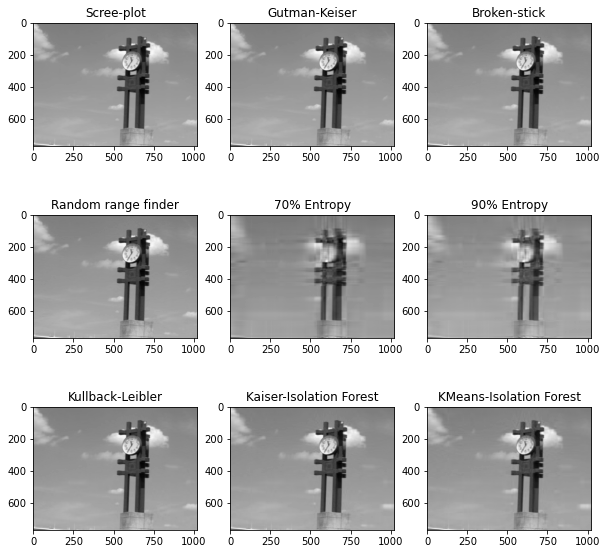

In [34]:
fig, axarr=plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

axarr[0,0].imshow(Rec_scree, cmap='gray')
axarr[0,0].set_title("Scree-plot")
axarr[0,1].imshow(Rec_GK, cmap='gray')
axarr[0,1].set_title("Gutman-Keiser")
axarr[0,2].imshow(Rec_bstick, cmap='gray')
axarr[0,2].set_title("Broken-stick")
axarr[1,0].imshow(Recon, cmap='gray')
axarr[1,0].set_title("Random range finder")
axarr[1,1].imshow(Rec_Ep70, cmap='gray')
axarr[1,1].set_title("70% Entropy")
axarr[1,2].imshow(Rec_Ep90, cmap='gray')
axarr[1,2].set_title("90% Entropy")
axarr[2,0].imshow(Rec_KL, cmap='gray')
axarr[2,0].set_title("Kullback-Leibler")
axarr[2,1].imshow(Rec_an1, cmap='gray')
axarr[2,1].set_title("Kaiser-Isolation Forest")
axarr[2,2].imshow(Rec_an2, cmap='gray')
axarr[2,2].set_title("KMeans-Isolation Forest")
#axarr[1,4].imshow(Rec_an2_full, cmap='gray')
#axarr[1,4].set_title("Anomaly detection 2, full")